<a href="https://colab.research.google.com/github/myazdani/gan-toy-datasets/blob/main/score-matching-swiss-roll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Ref](https://github.com/acids-ircam/diffusion_models/blob/main/diffusion_01_score.ipynb)


- How can we estimate $p(\mathbf{x})$?
- Instead of learning $p(\mathbf{x})$, we rather aim to learn the gradients $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ 
- the gradients $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ are termed the _score_ of the density $p(\mathbf{x})$
- Let's train a network $\mathcal{F}_{\theta}(\mathbf{x})$ with a  loss function looks that matches the score:
$$ \mathcal{L}_{mse} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \left\lVert \mathcal{F}_{\theta}(\mathbf{x}) - \nabla_{\mathbf{x}} \log p(\mathbf{x}) \right\lVert_2^2 \right] $$
- This is just a regression loss but the challenge is the target function $\nabla_{\mathbf{x}} \log p(\mathbf{x})$  is unkonwn
- It turns out through some math magic we can re-write thie regression fucntion like this:

$$ \mathcal{L}_{matching} = E_{\mathbf{x} \sim p(\mathbf{x})} \left[ \text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x})  \right) + \frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2 \right]
, $$

- where $\nabla_{\mathbf{x}} \mathcal{F}_{\theta}(\mathbf{x})$ denotes the Jacobian of $\mathcal{F}_{\theta}(\mathbf{x})$ with respect to $\mathbf{x}$, and $ \text{tr}(\cdot) $ is the _trace_ operation. Proof given in the appendix [here](https://www.jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf)
- OK, so now we have to compute two things:
  - the norm of the model output $\frac{1}{2} \left\Vert \mathcal{F}_{\theta}(\mathbf{x}) \right\lVert_2^2$
  - the trace of the Jacobian loss $\text{ tr}\left( \nabla_{\mathbf{x}}  \mathcal{F}_{\theta}(\mathbf{x}) \right)$

That Jacobian term is gonna be expensive but let's roll with it!  

#### generate some toy data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll

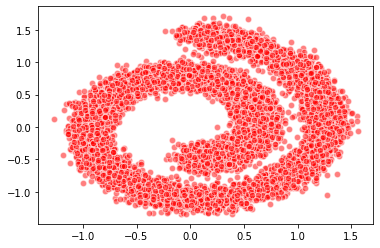

In [2]:
# Sample a batch from the swiss roll
def sample_batch(size, noise=1.0):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

data = sample_batch(10**4).T
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40);

#### model architecture

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(), # smooth relu
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#### jacobian

In [4]:
import torch.autograd as autograd

def manual_jacobian(f, x):
    """Computes the Jacobian of f w.r.t x.
    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """
    B, N = x.shape
    y = f(x)
    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = autograd.grad(y, x, grad_outputs=v, retain_graph=True, create_graph=True, allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)
    jacobian = torch.stack(jacobian, dim=2).requires_grad_()
    return jacobian

#### score matching loss

In [5]:
def score_matching(model, samples, train=False):
    samples.requires_grad_(True)
    logp = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(logp, dim=-1) ** 2 / 2.
    # Compute the Jacobian loss
    jacob_mat = manual_jacobian(model, samples)
    #jacob_mat = autograd.functional.jacobian(model, samples, create_graph=True)
    tr_jacobian_loss = torch.diagonal(jacob_mat, dim1=-2, dim2=-1).sum(-1)
    return (tr_jacobian_loss + norm_loss).mean(-1)

#### training

In [6]:
%%time
dataset = torch.tensor(data.T).float()
for t in range(50):
    # Compute the loss.
    loss = score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    if ((t % 10) == 0):
        print(loss)

tensor(0.0617, grad_fn=<MeanBackward1>)
tensor(-0.8753, grad_fn=<MeanBackward1>)
tensor(-1.7423, grad_fn=<MeanBackward1>)
tensor(-2.1198, grad_fn=<MeanBackward1>)
tensor(-2.0834, grad_fn=<MeanBackward1>)
CPU times: user 17 s, sys: 489 ms, total: 17.5 s
Wall time: 17.8 s


In [ ]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.tensor(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='red', edgecolor='black', s=40)
    plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)
plot_gradients(model, data)

## OK we got the gradients, but how do we generate smaples? Langevin dynamics